# Week 11 - density-based spatial clustering of applications with noise (DBSCAN), hierarchical agglomerative clustering (HAC), linkage methods in HAC, and dendrograms

In [1]:
# =============================
# Standard Library
# =============================
import io
import json
import logging
import math
import os
import re
import time
import warnings
import zipfile
from itertools import chain, combinations
from urllib.parse import urlparse

# =============================
# General / Utility (3rd party)
# =============================
import requests
import kagglehub
from IPython.display import display
from tqdm.auto import tqdm
from joblib import Parallel, delayed, parallel_backend
from collections import Counter

# =============================
# Data / Scientific
# =============================
import numpy as np
import pandas as pd
import optuna
import scipy.stats as stats
from scipy import sparse
from scipy.special import expit, logit
from scipy.stats import loguniform, randint, uniform
from scipy.cluster.hierarchy import linkage, dendrogram


# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
import seaborn as sns

# =============================
# Imbalanced-Learn
# =============================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# =============================
# Scikit-learn (core / model selection)
# =============================
from sklearn import clone
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.exceptions import ConvergenceWarning, NotFittedError
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    SelectKBest,
    VarianceThreshold,
    f_classif,
    f_regression,
    mutual_info_classif,
    mutual_info_regression,
)
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import (
    ElasticNet,
    ElasticNetCV,
    Lasso,
    LassoCV,
    LinearRegression,
    LogisticRegression,
    Ridge,
    RidgeCV,
    RidgeClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    get_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    ParameterGrid,
    ParameterSampler,
    RandomizedSearchCV,
    RepeatedKFold,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    TimeSeriesSplit,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
import sklearn.model_selection._search as sk_search
import sklearn.model_selection._validation as sk_validation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    MultiLabelBinarizer,
    Normalizer,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

# =============================
# Scikit-learn (ensembles)
# =============================
from sklearn.ensemble import (
    BaggingRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)



# =============================
# Global Settings
# =============================
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)

random_state = 42
N_ROWS = 50_000
pd.set_option("display.float_format", lambda x: f"{x:.6f}")  # no scientific notation

def robust_eda(df, name):
    # simple settings
    top_k_categories = 20
    max_corr_cols = 30
    max_rows_to_show = 25

    # make printing wide and avoid scientific notation
    with pd.option_context(
        "display.max_rows", max_rows_to_show,
        "display.max_columns", None,
        "display.width", 1000,
        "display.max_colwidth", 200,
        "display.float_format", lambda x: f"{x:.6f}"
    ):
        report_lines = []

        # title
        report_lines.append(f"=== Robust EDA Report: {name} ===")

        # shapes and memory
        info_df = pd.DataFrame(
            {
                "rows": [df.shape[0]],
                "columns": [df.shape[1]],
                "memory_bytes": [int(df.memory_usage(deep=True).sum())],
            }
        )
        report_lines.append("\n=== Info ===")
        report_lines.append(info_df.to_string(index=False))

        # dtypes
        dtypes_df = (
            df.dtypes.rename("dtype")
            .astype(str)
            .reset_index()
            .rename(columns={"index": "column"})
            .sort_values("column")
            .reset_index(drop=True)
        )
        report_lines.append("\n=== Dtypes ===")
        report_lines.append(dtypes_df.head(max_rows_to_show).to_string(index=False))

        # missing values
        total_rows = len(df)
        missing_counts = df.isna().sum()
        if total_rows > 0:
            missing_percent = (missing_counts / total_rows * 100).round(2)
        else:
            missing_percent = pd.Series([0] * len(df.columns), index=df.columns)
        missing_df = (
            pd.DataFrame(
                {
                    "column": df.columns,
                    "missing_count": missing_counts.values,
                    "missing_percent": missing_percent.values,
                }
            )
            .sort_values(["missing_count", "missing_percent"], ascending=False)
            .reset_index(drop=True)
        )
        report_lines.append("\n=== Missing Values ===")
        report_lines.append(missing_df.head(max_rows_to_show).to_string(index=False))

        # duplicates (safe fallback for unhashable types)
        try:
            duplicate_count = int(df.duplicated().sum())
            duplicate_index = df.index[df.duplicated(keep=False)]
            duplicates_preview_df = df.loc[duplicate_index].head(20)
        except TypeError:
            df_hashable = df.astype(str)
            duplicate_count = int(df_hashable.duplicated().sum())
            duplicate_index = df_hashable.index[df_hashable.duplicated(keep=False)]
            duplicates_preview_df = df.loc[duplicate_index].head(20)

        duplicates_summary_df = pd.DataFrame({"duplicate_rows": [duplicate_count]})
        report_lines.append("\n=== Duplicates Summary ===")
        report_lines.append(duplicates_summary_df.to_string(index=False))
        report_lines.append("\n=== Duplicates Preview (up to 20 rows) ===")
        if len(duplicates_preview_df) > 0:
            report_lines.append(duplicates_preview_df.to_string(index=False))
        else:
            report_lines.append("(No duplicate rows found.)")

        # column groups
        numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
        categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

        # numeric summary
        if len(numeric_columns) > 0:
            percentiles = [0.05, 0.25, 0.50, 0.75, 0.95]
            numeric_summary_df = (
                df[numeric_columns]
                .describe(percentiles=percentiles)
                .T.reset_index()
                .rename(columns={"index": "column"})
            )
            report_lines.append("\n=== Numeric Summary (5%..95%) ===")
            report_lines.append(numeric_summary_df.head(max_rows_to_show).to_string(index=False))

            # skew and kurtosis
            skew_kurt_df = pd.DataFrame(
                {
                    "column": numeric_columns,
                    "skew": df[numeric_columns].skew(numeric_only=True).values,
                    "kurtosis": df[numeric_columns].kurtosis(numeric_only=True).values,
                }
            )
            report_lines.append("\n=== Skew and Kurtosis ===")
            report_lines.append(skew_kurt_df.head(max_rows_to_show).to_string(index=False))

            # IQR outliers per column
            q1 = df[numeric_columns].quantile(0.25)
            q3 = df[numeric_columns].quantile(0.75)
            iqr = q3 - q1
            outlier_mask = (df[numeric_columns] < (q1 - 1.5 * iqr)) | (df[numeric_columns] > (q3 + 1.5 * iqr))
            iqr_outliers_df = (
                outlier_mask.sum()
                .rename("outlier_count")
                .reset_index()
                .rename(columns={"index": "column"})
            )
            report_lines.append("\n=== IQR Outlier Counts ===")
            report_lines.append(iqr_outliers_df.head(max_rows_to_show).to_string(index=False))

            # correlation on first N numeric columns
            if len(numeric_columns) > 1:
                selected_cols = numeric_columns[:max_corr_cols]
                correlation_df = df[selected_cols].corr(method="pearson", numeric_only=True)
                correlation_df.index.name = "column"
                report_lines.append(f"\n=== Correlation (first {max_corr_cols} numeric columns) ===")
                report_lines.append(correlation_df.to_string())
        else:
            report_lines.append("\n(No numeric columns found.)")

        # categorical value counts (top K each)
        if len(categorical_columns) > 0:
            cat_rows = []
            for col in categorical_columns:
                try:
                    vc = df[col].value_counts(dropna=False).head(top_k_categories)
                except TypeError:
                    vc = df[col].astype(str).value_counts(dropna=False).head(top_k_categories)
                for value, count in vc.items():
                    percent = (count / total_rows * 100) if total_rows > 0 else 0
                    cat_rows.append(
                        {"column": col, "value": value, "count": int(count), "percent": round(percent, 2)}
                    )
            categorical_values_df = pd.DataFrame(cat_rows)
            report_lines.append(f"\n=== Categorical Values (Top {top_k_categories} per column) ===")
            report_lines.append(categorical_values_df.head(max_rows_to_show).to_string(index=False))
        else:
            report_lines.append("\n(No categorical columns found.)")

        # unique counts per column
        def _safe_nunique(series):
            try:
                return int(series.nunique(dropna=False))
            except TypeError:
                return np.nan

        unique_counts_df = pd.DataFrame(
            {"column": df.columns, "unique_values": [_safe_nunique(df[c]) for c in df.columns]}
        )
        report_lines.append("\n=== Unique Counts Per Column ===")
        report_lines.append(unique_counts_df.head(max_rows_to_show).to_string(index=False))

        # sample head
        report_lines.append("\n=== Head (10 rows) ===")
        report_lines.append(df.head(10).to_string(index=False))

        # end
        report_lines.append("\n=== End of EDA Report ===")

        # one giant print
        print("\n".join(report_lines))


def is_sparse_dtype(dtype):
    # check if a dtype is pandas sparse
        return pd.api.types.is_sparse(dtype)

def dollar_format(x, pos=None):
    # format money like $12,345
    return f"${x:,.0f}"

def format_hms(seconds):
    # format seconds to H:M:S and handle >24 hours
    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

def try_read_csv(folder_path, file_name, **kwargs):
    # try to read a csv; file_name can be a full path
    full_path = os.path.join(folder_path, file_name) if folder_path else file_name
    if full_path and os.path.exists(full_path):
        try:
            return pd.read_csv(full_path, **kwargs)
        except Exception:
            return None
    return None

def list_csvs(folder_path):
    # list csv files (sorted)
    if not folder_path or not os.path.exists(folder_path):
        return []
    return sorted([f for f in os.listdir(folder_path) if f.lower().endswith(".csv")])

def simple_random_sample(data_frame, n_rows=None, frac=None, random_state=42):
    # sample without replacement
    if data_frame is None:
        raise ValueError("data_frame is None")
    total_rows = len(data_frame)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")

    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be between 0 and 1")
        pick_rows = int(np.floor(frac * total_rows))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        pick_rows = min(int(n_rows), total_rows)

    if pick_rows >= total_rows:
        print("simple_random_sample: taking all rows")
        return data_frame.copy()

    start = time.perf_counter()
    rng = np.random.default_rng(random_state)
    pick_index = rng.choice(total_rows, size=pick_rows, replace=False)
    pick_index = np.sort(pick_index)  # keep original order
    out_df = data_frame.iloc[pick_index].copy()
    end = time.perf_counter()
    print(f"simple_random_sample: picked {len(out_df)} of {total_rows} rows in {round(end - start, 3)} sec")
    return out_df

def stratified_sample(data_frame, y, n_rows=None, frac=None, random_state=42):
    # stratified sample on labels y
    if data_frame is None:
        raise ValueError("data_frame is None")

    y_array = data_frame[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    total_rows = len(data_frame)
    if len(y_array) != total_rows:
        raise ValueError("X and y length mismatch")

    # prefer n_rows if both given
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")

    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be between 0 and 1")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / total_rows, 1.0)
        use_frac, use_n = None, int(n_rows)

    if test_size >= 1.0:
        print("stratified_sample: taking all rows")
        return data_frame.copy()

    _, counts = np.unique(y_array, return_counts=True)
    min_count = counts.min()

    # need at least 1 per class in both splits
    if min_count < 2 or (min_count * test_size < 1) or (min_count * (1.0 - test_size) < 1):
        print("stratified_sample: class counts too small for requested size, falling back to simple sample")
        return simple_random_sample(data_frame, n_rows=use_n, frac=use_frac, random_state=random_state)

    start = time.perf_counter()
    index_array = np.arange(total_rows)
    _, test_idx, _, _ = train_test_split(
        index_array,
        y_array,
        test_size=test_size,
        stratify=y_array,
        random_state=random_state
    )
    out_df = data_frame.iloc[np.sort(test_idx)].copy()  # keep original order
    end = time.perf_counter()
    print(f"stratified_sample: picked {len(out_df)} of {total_rows} rows in {round(end - start, 3)} sec")
    return out_df

def safe_kaggle_download(dataset_name):
    # download from kaggle with timing and errors
    print(f"download: starting {dataset_name}")
    start = time.perf_counter()
    try:
        path = kagglehub.dataset_download(dataset_name)
        end = time.perf_counter()
        print(f"download: done {dataset_name} -> {path} in {round(end - start, 3)} sec")
        return path
    except Exception as e:
        end = time.perf_counter()
        print(f"download: error {dataset_name} -> {str(e)} in {round(end - start, 3)} sec")
        return None

def coerce_datetime_columns(df):
    # convert likely date/time columns if they are strings
    if df is None:
        return None
    print("dates: converting possible date/time columns")
    for col_name in df.columns:
        lower = col_name.lower()
        if ("date" in lower) or ("time" in lower):
            s = df[col_name]
            try:
                if pd.api.types.is_object_dtype(s) or pd.api.types.is_string_dtype(s):
                    df[col_name] = pd.to_datetime(s, errors="coerce")
            except Exception:
                pass
    return df

def float_range(start, stop, step):
    # float range with guards and tolerance
    if step == 0:
        raise ValueError("step must not be 0")
    values = []
    value = float(start)
    tolerance = abs(step) / 1_000_000
    if step > 0:
        while value <= stop + tolerance:
            values.append(round(value, 12))
            value += step
    else:
        while value >= stop - tolerance:
            values.append(round(value, 12))
            value += step
    return values


# =============================
# Steam Loader
# =============================
def load_steam_dataset(base_path, n_rows=100_000, seed=42):
    print("steam: start")
    if base_path is None:
        print("steam: skip because base_path is None")
        return None

    games = try_read_csv(base_path, "games.csv", low_memory=False)
    users = try_read_csv(base_path, "users.csv", low_memory=False)
    recommendations = try_read_csv(base_path, "recommendations.csv", low_memory=False)

    metadata = None
    meta_path = os.path.join(base_path, "games_metadata.json")
    if os.path.exists(meta_path):
        try:
            metadata = pd.read_json(meta_path, lines=True)
        except Exception as e:
            print(f"steam: metadata read error -> {str(e)}")

    print(
        f"steam: shapes games={None if games is None else games.shape}, "
        f"users={None if users is None else users.shape}, "
        f"recs={None if recommendations is None else recommendations.shape}, "
        f"meta={None if metadata is None else metadata.shape}"
    )

    steam_table = None
    if recommendations is not None:
        if "is_recommended" in recommendations.columns:
            recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=n_rows, random_state=seed)
        else:
            recs_sample = simple_random_sample(recommendations, n_rows=n_rows, random_state=seed)

        games_plus = games
        if (
            metadata is not None
            and games is not None
            and "app_id" in metadata.columns
            and "app_id" in games.columns
        ):
            print("steam: merge games with metadata")
            games_plus = games.merge(metadata, on="app_id", how="left", suffixes=("", "_meta"))

        steam_table = recs_sample
        if games_plus is not None and "app_id" in recs_sample.columns and "app_id" in games_plus.columns:
            print("steam: merge recommendations with games")
            steam_table = steam_table.merge(games_plus, on="app_id", how="left", suffixes=("", "_game"))

        if users is not None and "user_id" in steam_table.columns and "user_id" in users.columns:
            print("steam: merge with users")
            steam_table = steam_table.merge(users, on="user_id", how="left", suffixes=("", "_user"))

        steam_table = coerce_datetime_columns(steam_table)
        print(f"steam: done shape={None if steam_table is None else steam_table.shape}")
    else:
        print("steam: skip because recommendations.csv is missing")

    return steam_table


# =============================
# Olist Loader
# =============================
def load_olist_dataset(base_path, n_rows=1_000_000, seed=42):
    print("olist: start")
    if base_path is None:
        print("olist: skip because base_path is None")
        return None

    olist_customers = try_read_csv(base_path, "olist_customers_dataset.csv", low_memory=False)
    olist_geolocation = try_read_csv(base_path, "olist_geolocation_dataset.csv", low_memory=False)
    olist_items = try_read_csv(base_path, "olist_order_items_dataset.csv", low_memory=False)
    olist_payments = try_read_csv(base_path, "olist_order_payments_dataset.csv", low_memory=False)
    olist_reviews = try_read_csv(base_path, "olist_order_reviews_dataset.csv", low_memory=False)
    olist_orders = try_read_csv(base_path, "olist_orders_dataset.csv", low_memory=False)
    olist_products = try_read_csv(base_path, "olist_products_dataset.csv", low_memory=False)
    olist_sellers = try_read_csv(base_path, "olist_sellers_dataset.csv", low_memory=False)
    olist_cat_trans = try_read_csv(base_path, "product_category_name_translation.csv", low_memory=False)

    print(
        "olist: shapes "
        f"customers={None if olist_customers is None else olist_customers.shape}, "
        f"geolocation={None if olist_geolocation is None else olist_geolocation.shape}, "
        f"items={None if olist_items is None else olist_items.shape}, "
        f"payments={None if olist_payments is None else olist_payments.shape}, "
        f"reviews={None if olist_reviews is None else olist_reviews.shape}, "
        f"orders={None if olist_orders is None else olist_orders.shape}, "
        f"products={None if olist_products is None else olist_products.shape}, "
        f"sellers={None if olist_sellers is None else olist_sellers.shape}, "
        f"cat_trans={None if olist_cat_trans is None else olist_cat_trans.shape}"
    )

    if not all(x is not None for x in [olist_orders, olist_items, olist_products, olist_sellers, olist_customers]):
        print("olist: skip because core tables are missing")
        return None

    print("olist: sample orders")
    orders_small = simple_random_sample(olist_orders, n_rows=min(n_rows, len(olist_orders)), random_state=seed)

    print("olist: filter items for sampled orders")
    items_small = olist_items[olist_items["order_id"].isin(orders_small["order_id"])].copy()

    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        print("olist: merge category translation")
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    if olist_reviews is not None:
        print("olist: build product review stats")
        product_reviews = (
            items_small[["order_id", "product_id"]]
            .merge(olist_reviews[["order_id", "review_score"]], on="order_id", how="inner")
        )
        product_reviews = product_reviews.drop_duplicates(["order_id", "product_id"])
        product_stats = (
            product_reviews.groupby("product_id", as_index=False)
            .agg(
                review_count_product=("review_score", "count"),
                review_score_mean_product=("review_score", "mean"),
            )
        )
    else:
        product_stats = None

    print("olist: merge items, products, and sellers")
    items_ext = (
        items_small.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    if olist_geolocation is not None:
        print("olist: build basic zip geo")
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        print("olist: merge customers with geo")
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    if olist_payments is not None:
        print("olist: aggregate payments")
        payments_agg = (
            olist_payments.groupby("order_id", as_index=False).agg(
                payment_value_total=("payment_value", "sum"),
                payment_installments_max=("payment_installments", "max"),
                payment_count=("payment_type", "count"),
            )
        )
    else:
        payments_agg = None

    print("olist: assemble main table")
    olist_full = (
        orders_small.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )

    if payments_agg is not None:
        print("olist: merge payments")
        olist_full = olist_full.merge(payments_agg, on="order_id", how="left")

    if product_stats is not None:
        print("olist: merge product stats")
        olist_full = olist_full.merge(product_stats, on="product_id", how="left")

    olist_full = coerce_datetime_columns(olist_full)

    print(f"olist: shape after assemble {olist_full.shape}")
    print("olist: done")
    return olist_full


# =============================
# VG2019 Loader
# =============================
def load_vg2019_dataset(base_path, n_rows=1_000_000, seed=42):
    print("vg2019: start")
    if base_path is None:
        print("vg2019: skip because base_path is None")
        return None

    csv_files = list_csvs(base_path)
    pick = None
    for f in csv_files:
        if "vgsales" in f.lower():
            pick = f
            break
    target_csv = pick if pick else (csv_files[0] if csv_files else None)

    if target_csv is None:
        print("vg2019: skip because no csv found")
        return None

    full_path = os.path.join(base_path, target_csv)
    try:
        sales = pd.read_csv(full_path, low_memory=False)
    except Exception as e:
        print(f"vg2019: read error -> {str(e)}")
        return None

    print(f"vg2019: loaded {target_csv} with shape {sales.shape}")

    if "Genre" in sales.columns:
        print("vg2019: stratified sample by Genre")
        sales = stratified_sample(sales, y="Genre", n_rows=n_rows, random_state=seed)
    else:
        print("vg2019: simple random sample")
        sales = simple_random_sample(sales, n_rows=n_rows, random_state=seed)

    print(f"vg2019: done shape={sales.shape}")
    return sales


# =========================
# Timer + memory helpers
# =========================
class SimpleTimer:
    def __init__(self, enabled=True):
        self.enabled = enabled
        self.t0 = time.perf_counter()

    def tick(self, label):
        if not self.enabled:
            return
        t = time.perf_counter() - self.t0
        print(f"[timer] {label}: {t:.2f} s")
        self.t0 = time.perf_counter()


def df_mem_gb(df):
    try:
        return float(df.memory_usage(deep=True).sum()) / (1024 ** 3)
    except Exception:
        return float("nan")


def show_shape_mem(label, X_train=None, X_test=None):
    parts = [label]
    if X_train is not None:
        parts.append(f"X_train shape={tuple(X_train.shape)} mem={df_mem_gb(X_train):.3f} GB")
    if X_test is not None:
        parts.append(f"X_test shape={tuple(X_test.shape)} mem={df_mem_gb(X_test):.3f} GB")
    print("[info]", " | ".join(parts))


# =========================
# Text feature helpers (fast)
# =========================
def clean_keyword_name(s):
    s = str(s).lower().strip().replace(" ", "_")
    keep = []
    for ch in s:
        if ch.isalnum() or ch == "_":
            keep.append(ch)
    return "".join(keep)[:60]


def text_features_fit(X, keyword_map):
    keyword_map = keyword_map or {}
    new_cols = []
    new_parts = []

    for col, keywords in keyword_map.items():
        if col not in X.columns:
            continue
        if str(X[col].dtype) not in ["object", "category"]:
            continue
        if col == "tags":
            continue

        col_str = X[col].fillna("").astype(str).str.lower()
        len_col = f"{col}_len"
        wc_col = f"{col}_wc"

        part = {
            len_col: col_str.str.len(),
            wc_col: col_str.str.split().apply(len),
        }
        for kw in keywords:
            safe = clean_keyword_name(kw)
            name = f"{col}_has_{safe}"
            part[name] = col_str.str.contains(str(kw).lower(), regex=False).astype(np.uint8)

        df_part = pd.DataFrame(part, index=X.index)
        new_parts.append(df_part)
        new_cols.extend(df_part.columns.tolist())

    if new_parts:
        X_new = pd.concat(new_parts, axis=1)
        X = pd.concat([X, X_new], axis=1)

    return {"new_cols": new_cols, "keyword_map": keyword_map}


def text_features_apply(X, text_info):
    keyword_map = text_info.get("keyword_map") or {}
    new_parts = []

    for col, keywords in keyword_map.items():
        len_col = f"{col}_len"
        wc_col = f"{col}_wc"

        if col not in X.columns:
            part = {
                len_col: pd.Series(0, index=X.index, dtype=np.int64),
                wc_col: pd.Series(0, index=X.index, dtype=np.int64),
            }
            for kw in keywords:
                name = f"{col}_has_{clean_keyword_name(kw)}"
                part[name] = pd.Series(0, index=X.index, dtype=np.uint8)
            new_parts.append(pd.DataFrame(part, index=X.index))
            continue

        if str(X[col].dtype) not in ["object", "category"] or col == "tags":
            continue

        col_str = X[col].fillna("").astype(str).str.lower()
        part = {
            len_col: col_str.str.len(),
            wc_col: col_str.str.split().apply(len),
        }
        for kw in keywords:
            name = f"{col}_has_{clean_keyword_name(kw)}"
            part[name] = col_str.str.contains(str(kw).lower(), regex=False).astype(np.uint8)

        new_parts.append(pd.DataFrame(part, index=X.index))

    if new_parts:
        X_new = pd.concat(new_parts, axis=1)
        X = pd.concat([X, X_new], axis=1)

    for c in text_info.get("new_cols", []):
        if c not in X.columns:
            X[c] = 0

    return X


def add_text_length_features_inplace(X, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    obj_cols = [c for c in X.columns if str(X[c].dtype) in ["object", "category"] and c not in exclude_cols]
    for c in obj_cols:
        X[f"{c}_length"] = X[c].fillna("").astype(str).str.len().astype("int32")
    return X


# =========================
# General helpers
# =========================
def datetimes_to_numeric_inplace(X):
    for c in X.columns:
        if np.issubdtype(X[c].dtype, np.datetime64):
            mask = X[c].isna()
            vals_int = X[c].values.astype("datetime64[ns]").astype("int64")
            arr = vals_int.astype("float64") / 1000000000.0
            if mask.any():
                arr[mask.values] = np.nan
            X[c] = arr
    return X


def downcast_numeric_inplace(X):
    for c in X.columns:
        dt = X[c].dtype
        if np.issubdtype(dt, np.floating):
            X[c] = X[c].astype("float32")
        elif np.issubdtype(dt, np.integer) and X[c].nunique(dropna=True) > 2:
            X[c] = X[c].astype("int32")
    return X


def scale_fit(method, X_train_num):
    if method == "standard":
        return StandardScaler().fit(X_train_num)
    if method == "minmax":
        return MinMaxScaler().fit(X_train_num)
    return None


def scale_numeric_only(X_train, X_test, scale_method):
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    if not num_cols:
        return X_train, X_test
    scaler = scale_fit(scale_method, X_train[num_cols])
    if scaler is None:
        return X_train, X_test
    X_train[num_cols] = scaler.transform(X_train[num_cols]).astype("float32")
    X_test[num_cols] = scaler.transform(X_test[num_cols]).astype("float32")
    return X_train, X_test


# =========================
# Safer OHE with caps
# =========================
def _auto_exclude_mask(series, max_unique=500, max_avg_len=25):
    s = series.fillna("Unknown").astype(str)
    nunq = int(s.nunique(dropna=False))
    avg_len = float(s.map(len).mean())
    return (nunq > max_unique) or (avg_len > max_avg_len and nunq > 50)


def _cap_categories(series, top_k=100, min_freq=1, other_label="Other"):
    s = series.fillna("Unknown").astype(str)
    vc = s.value_counts()
    kept = vc[vc >= min_freq].index.tolist()
    if top_k is not None and len(kept) > top_k:
        kept = vc.index[:top_k].tolist()
    mapped = s.where(s.isin(kept), other_label)
    return mapped.astype("category"), kept


def ohe_fit(
    X,
    exclude_cols=None,
    top_k_per_col=100,
    min_freq_per_col=1,
    auto_exclude=False,
    high_card_threshold=500,
    long_text_avglen=25,
):
    exclude = set(exclude_cols or [])
    value_map = {}

    X_tmp = X.copy()
    obj_cols = [c for c in X_tmp.select_dtypes(include=["object", "category"]).columns]
    excluded = list(exclude)

    for c in obj_cols:
        if c in exclude:
            continue
        s = X_tmp[c]
        if auto_exclude:
            if _auto_exclude_mask(s, max_unique=high_card_threshold, max_avg_len=long_text_avglen):
                excluded.append(c)
                continue
        capped, kept = _cap_categories(s, top_k=top_k_per_col, min_freq=min_freq_per_col)
        X_tmp[c] = capped
        value_map[c] = kept

    X_tmp = X_tmp.drop(columns=excluded, errors="ignore")
    obj_cols_final = [c for c in obj_cols if c not in excluded]

    X_ohe = pd.get_dummies(X_tmp, columns=obj_cols_final, dummy_na=False)
    schema_cols = X_ohe.columns.tolist()

    return {
        "obj_cols": obj_cols_final,
        "schema_cols": schema_cols,
        "value_map": value_map,
        "excluded": excluded,
        "other_label": "Other",
    }


def ohe_apply(X, ohe_info):
    obj_cols = ohe_info["obj_cols"]
    schema_cols = ohe_info["schema_cols"]
    value_map = ohe_info["value_map"]
    other = ohe_info.get("other_label", "Other")
    excluded = ohe_info.get("excluded", [])

    X_tmp = X.drop(columns=excluded, errors="ignore").copy()

    for c in obj_cols:
        if c in X_tmp.columns:
            s = X_tmp[c].fillna("Unknown").astype(str)
            kept = set(value_map.get(c, []))
            s = s.where(s.isin(kept), other).astype("category")
            X_tmp[c] = s

    X_ohe = pd.get_dummies(X_tmp, columns=[c for c in obj_cols if c in X_tmp.columns], dummy_na=False)
    X_ohe = X_ohe.reindex(columns=schema_cols, fill_value=0)
    return X_ohe


# =========================
# Outliers
# =========================
def outlier_bounds_fit(X_num, lower_q=0.025, upper_q=0.975, exclude_binary=True, sample_rows=200000):
    bounds = {}
    if lower_q is None or upper_q is None:
        return bounds
    X_use = X_num
    if len(X_num) > sample_rows:
        X_use = X_num.sample(n=sample_rows, random_state=123)
    for c in X_use.columns:
        vals = X_use[c].astype("float32")
        if exclude_binary and X_use[c].nunique(dropna=True) <= 2:
            continue
        lo = np.nanquantile(vals, lower_q)
        hi = np.nanquantile(vals, upper_q)
        if np.isfinite(lo) and np.isfinite(hi) and hi >= lo:
            bounds[c] = (float(lo), float(hi))
    return bounds


def outlier_clip_inplace(X, bounds):
    if not bounds:
        return X
    for c, (lo, hi) in bounds.items():
        if c in X.columns:
            X[c] = X[c].astype("float32").clip(lo, hi)
    return X


# =========================
# Feature selection
# =========================
def forward_feature_selection(X, y, model,
                              scoring="neg_mean_absolute_error",
                              cv=5, tol=None, max_features=None, n_jobs=-1, verbose=False):
    try:
        feature_names = list(X.columns)
        X_arr = X.values
    except AttributeError:
        X_arr = X
        feature_names = [f"f{i}" for i in range(X_arr.shape[1])]

    selected_idx = []
    remaining_idx = list(range(X_arr.shape[1]))
    best_scores = []
    previous_score = float("inf")
    best_feature_set_idx = []
    best_score = float("inf")

    while remaining_idx:
        scores = {}
        for idx in remaining_idx:
            trial_idx = selected_idx + [idx]
            cv_score = -cross_val_score(
                model, X_arr[:, trial_idx], y,
                scoring=scoring, cv=cv, n_jobs=n_jobs
            ).mean()
            scores[idx] = cv_score

        best_idx = min(scores, key=scores.get)
        current_score = scores[best_idx]

        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early (improvement < tol).")
            break

        selected_idx.append(best_idx)
        remaining_idx.remove(best_idx)
        best_scores.append(current_score)
        previous_score = current_score

        if verbose:
            name = feature_names[best_idx]
            print(f"Added {name} -> CV score = {current_score:.4f}")

        if current_score < best_score:
            best_score = current_score
            best_feature_set_idx = selected_idx.copy()

        if max_features is not None and len(selected_idx) >= max_features:
            break

    selected_features = [feature_names[i] for i in selected_idx]
    best_feature_set = [feature_names[i] for i in best_feature_set_idx]

    if not best_feature_set:
        best_feature_set = selected_features[:]
        best_score = best_scores[-1] if best_scores else float("inf")

    if verbose:
        try:
            index = np.argmax(np.array(selected_features) == best_feature_set[-1])
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(best_scores) + 1), best_scores, marker=".")
            plt.plot([index + 1], [best_score], marker="x")
            plt.xticks(range(1, len(selected_features) + 1),
                       selected_features, rotation=60, ha="right", fontsize=6)
            plt.title("Forward Feature Selection and CV Scores")
            plt.xlabel("Features Added")
            plt.ylabel("CV Score (MAE)")
            plt.grid()
            plt.tight_layout()
            plt.show()
        except Exception:
            pass

        print(f"Best Features: {best_feature_set}")
        print(f"Best CV MAE Score: {best_score:.4f}")
    return selected_features, best_scores, best_feature_set, best_score


def select_features(method, max_features, task_type, random_state, X_train, y_train, verbose=False):
    if method is None or method == "none":
        return X_train.columns.tolist()

    k = min(max_features, X_train.shape[1]) if max_features else X_train.shape[1]
    if k < 1:
        return X_train.columns.tolist()

    if method == "tree":
        est = RandomForestClassifier(random_state=random_state) if task_type == "classification" else RandomForestRegressor(random_state=random_state)
        est.fit(X_train, y_train)
        imp = pd.Series(est.feature_importances_, index=X_train.columns)
        return imp.nlargest(k).index.tolist()

    if method == "forward":
        if task_type != "regression":
            raise ValueError("Forward selection is only supported for regression tasks.")
        model = RandomForestRegressor(random_state=random_state)
        _, _, best_set, _ = forward_feature_selection(
            X=X_train, y=y_train, model=model,
            scoring="neg_mean_absolute_error", cv=3,
            tol=None, max_features=max_features, n_jobs=-1, verbose=verbose
        )
        return best_set

    if method == "mutual_info":
        sel = SelectKBest(mutual_info_classif if task_type == "classification" else mutual_info_regression, k=k)
        sel.fit(X_train, y_train)
        return X_train.columns[sel.get_support()].tolist()

    return X_train.columns.tolist()


# =========================
# Batched poly features
# =========================
def add_poly_features_batched(X_train, X_test, squares, pairs):
    train_parts = {}
    for c in squares:
        if c in X_train.columns:
            train_parts[f"{c}_sq"] = X_train[c].astype("float32") ** 2
    for a, b in pairs:
        if (a in X_train.columns) and (b in X_train.columns):
            name = f"{a}_x_{b}"
            train_parts[name] = (X_train[a].astype("float32") * X_train[b].astype("float32"))

    test_parts = {}
    for name in train_parts:
        if name.endswith("_sq"):
            c = name[:-3]
            if c in X_test.columns:
                test_parts[name] = X_test[c].astype("float32") ** 2
            else:
                test_parts[name] = pd.Series(0.0, index=X_test.index, dtype="float32")
        else:
            a, b = name.split("_x_")
            if (a in X_test.columns) and (b in X_test.columns):
                test_parts[name] = (X_test[a].astype("float32") * X_test[b].astype("float32"))
            else:
                test_parts[name] = pd.Series(0.0, index=X_test.index, dtype="float32")

    if train_parts:
        X_train = pd.concat([X_train, pd.DataFrame(train_parts, index=X_train.index)], axis=1)
    if test_parts:
        X_test = pd.concat([X_test, pd.DataFrame(test_parts, index=X_test.index)], axis=1)

    X_train = downcast_numeric_inplace(X_train.copy())
    X_test = downcast_numeric_inplace(X_test.copy())
    return X_train, X_test


# =========================
# Main prep (with best hyperparameters per dataset)
# =========================
def prepare_data(
    steam_df,
    olist_df,
    sales_df,
    test_size,
    random_state,
    feature_selection=None,
    max_features=None,
    task_type="classification",
    scale_method=None,
    use_best_from_sweep=True,
    verbose=False,
):
    outputs = {}
    timer = SimpleTimer(enabled=verbose)

    if use_best_from_sweep:
        steam_hp = {
            "cutoff": 95.0,
            "feature_selection": "mutual_info",
            "max_features": 50,
            "scale_method": None,
            "ohe_auto_exclude": False,
            "tag_min_count": 5,
            "tag_top_k": 200,
            "ohe_top_k_per_col": 400,
            "ohe_min_freq_per_col": 5,
            "outlier_lower_q": 0.05,
            "outlier_upper_q": 0.95,
            "ohe_high_card_threshold": 300,
            "ohe_long_text_avglen": 25,
        }
        olist_hp = {
            "cutoff": 4.0,
            "feature_selection": "tree",
            "max_features": 10,
            "scale_method": None,
            "ohe_auto_exclude": True,
            "tag_min_count": 3,
            "tag_top_k": 400,
            "ohe_top_k_per_col": 400,
            "ohe_min_freq_per_col": 1,
            "outlier_lower_q": 0.01,
            "outlier_upper_q": 0.99,
            "ohe_high_card_threshold": 800,
            "ohe_long_text_avglen": 35,
        }
        sales_hp = {
            "cutoff": 5.0,
            "feature_selection": "mutual_info",
            "max_features": None,
            "scale_method": None,
            "ohe_auto_exclude": True,
            "tag_min_count": 10,
            "tag_top_k": 100,
            "ohe_top_k_per_col": 200,
            "ohe_min_freq_per_col": 5,
            "outlier_lower_q": 0.01,
            "outlier_upper_q": 0.99,
            "ohe_high_card_threshold": 800,
            "ohe_long_text_avglen": 20,
        }
    else:
        steam_hp = {
            "cutoff": 50.0,
            "feature_selection": (feature_selection or "none").lower(),
            "max_features": max_features,
            "scale_method": scale_method,
            "ohe_auto_exclude": False,
            "tag_min_count": 5,
            "tag_top_k": 200,
            "ohe_top_k_per_col": 100,
            "ohe_min_freq_per_col": 1,
            "outlier_lower_q": 0.025,
            "outlier_upper_q": 0.975,
            "ohe_high_card_threshold": 500,
            "ohe_long_text_avglen": 25,
        }
        olist_hp = steam_hp.copy()
        olist_hp["cutoff"] = 2.5
        sales_hp = steam_hp.copy()
        sales_hp["cutoff"] = 5.0

    # ---------- STEAM ----------
    steam = steam_df.copy()
    if task_type == "classification":
        steam["target"] = (steam["positive_ratio"] >= float(steam_hp["cutoff"])).astype(int)
    else:
        steam["target"] = steam["positive_ratio"]
    steam.dropna(subset=["target"], inplace=True)

    steam.drop(columns=["app_id", "user_id", "review_id", "positive_ratio"], errors="ignore", inplace=True)

    if {"date", "date_release"}.issubset(steam.columns):
        steam["days_since_release"] = (steam["date"] - steam["date_release"]).dt.days

    for col in ["is_recommended", "mac", "linux", "win", "steam_deck"]:
        if col in steam.columns:
            steam[col] = steam[col].astype(int)

    if "hours" in steam.columns:
        steam["log_hours"] = np.log1p(steam["hours"])
    if {"hours", "user_reviews"}.issubset(steam.columns):
        steam["reviews_per_hour"] = steam["user_reviews"] / (steam["hours"] + 0.000000001)

    X = steam.drop(columns=["target", "rating"], errors="ignore")
    y = steam["target"]
    strat = y if task_type == "classification" else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )
    timer.tick("steam split")
    if verbose:
        show_shape_mem("steam post split", X_train, X_test)

    datetimes_to_numeric_inplace(X_train)
    datetimes_to_numeric_inplace(X_test)
    timer.tick("steam datetime to numeric")

    add_text_length_features_inplace(X_train, exclude_cols=["tags"])
    add_text_length_features_inplace(X_test, exclude_cols=["tags"])

    steam_kw = {
        "title": ["vr", "dlc", "multiplayer", "co-op", "coop", "online", "free", "demo", "survival"],
        "description": ["vr", "dlc", "multiplayer", "co-op", "open world", "story", "puzzle", "horror", "early access"],
    }
    steam_text_info = text_features_fit(X_train, steam_kw)
    X_test = text_features_apply(X_test, steam_text_info)
    if verbose:
        timer.tick("steam text features")
        show_shape_mem("steam after text", X_train, X_test)

    if "tags" in X_train.columns:
        from collections import Counter

        def tag_col_name(t):
            s = str(t).lower().strip().replace(" ", "_")
            return "tag_" + "".join(ch for ch in s if ch.isalnum() or ch == "_")[:60]

        cnt = Counter()
        for v in X_train["tags"].fillna("").values:
            lst = v if isinstance(v, list) else []
            for t in lst:
                cnt[t] += 1

        items = [(t, n) for t, n in cnt.items() if n >= steam_hp["tag_min_count"]]
        items.sort(key=lambda x: x[1], reverse=True)
        vocab = [t for t, _ in items[:steam_hp["tag_top_k"]]]
        tag_cols = [tag_col_name(t) for t in vocab]
        if verbose:
            print(f"[info] steam tags unique={len(cnt)}, kept={len(vocab)} (min_count={steam_hp['tag_min_count']}, top_k={steam_hp['tag_top_k']})")

        def add_tag_cols_fast(df):
            if "tags" in df.columns:
                tag_lists = df["tags"].apply(lambda v: v if isinstance(v, list) else [])
            else:
                tag_lists = pd.Series([[]] * len(df), index=df.index)
            new_data = {}
            for tag, col_name in zip(vocab, tag_cols):
                new_data[col_name] = np.fromiter(
                    (1 if tag in lst else 0 for lst in tag_lists),
                    dtype=np.uint8,
                    count=len(df)
                )
            new_df = pd.DataFrame(new_data, index=df.index)
            return pd.concat([df.drop(columns=["tags"], errors="ignore"), new_df], axis=1)

        X_train = add_tag_cols_fast(X_train)
        X_test = add_tag_cols_fast(X_test)
        if verbose:
            timer.tick("steam tags multi-hot")
            show_shape_mem("steam after tags", X_train, X_test)

    ohe_info = ohe_fit(
        X_train,
        exclude_cols=[],
        top_k_per_col=steam_hp["ohe_top_k_per_col"],
        min_freq_per_col=steam_hp["ohe_min_freq_per_col"],
        auto_exclude=steam_hp["ohe_auto_exclude"],
        high_card_threshold=steam_hp["ohe_high_card_threshold"],
        long_text_avglen=steam_hp["ohe_long_text_avglen"],
    )
    X_train = ohe_apply(X_train, ohe_info)
    X_test = ohe_apply(X_test, ohe_info)
    timer.tick("steam OHE")
    if verbose:
        show_shape_mem("steam after OHE", X_train, X_test)

    X_train = X_train.select_dtypes(include=["number"]).copy()
    X_test = X_test.select_dtypes(include=["number"]).copy()
    if verbose:
        print("steam non-numeric after OHE:", X_train.select_dtypes(exclude=["number"]).columns.tolist())

    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    if num_cols:
        simp = SimpleImputer(strategy="median").fit(X_train[num_cols])
        X_train[num_cols] = simp.transform(X_train[num_cols])
        X_test[num_cols] = simp.transform(X_test[num_cols])
    timer.tick("steam impute")

    X_train = downcast_numeric_inplace(X_train)
    X_test = downcast_numeric_inplace(X_test)
    if verbose:
        show_shape_mem("steam after impute+downcast", X_train, X_test)

    steam_squares = []
    if "log_hours" in X_train.columns:
        steam_squares.append("log_hours")
    elif "hours" in X_train.columns:
        steam_squares.append("hours")
    if "discount" in X_train.columns:
        steam_squares.append("discount")
    if "days_since_release" in X_train.columns:
        steam_squares.append("days_since_release")

    steam_pairs = []
    if ("price_final" in X_train.columns) and ("discount" in X_train.columns):
        steam_pairs.append(("price_final", "discount"))
    if ("price_original" in X_train.columns) and ("discount" in X_train.columns):
        steam_pairs.append(("price_original", "discount"))
    if ("days_since_release" in X_train.columns) and ("discount" in X_train.columns):
        steam_pairs.append(("days_since_release", "discount"))
    if ("user_reviews" in X_train.columns) and ("reviews" in X_train.columns):
        steam_pairs.append(("user_reviews", "reviews"))

    X_train, X_test = add_poly_features_batched(X_train, X_test, steam_squares, steam_pairs)
    timer.tick("steam poly")
    if verbose:
        show_shape_mem("steam after poly", X_train, X_test)

    num_cols2 = X_train.select_dtypes(include=["number"]).columns.tolist()
    bounds = outlier_bounds_fit(
        X_train[num_cols2],
        lower_q=steam_hp["outlier_lower_q"],
        upper_q=steam_hp["outlier_upper_q"],
        exclude_binary=True,
        sample_rows=200000
    )
    X_train = outlier_clip_inplace(X_train, bounds)
    X_test = outlier_clip_inplace(X_test, bounds)
    timer.tick("steam outlier clip")
    if verbose:
        show_shape_mem("steam after outlier clip", X_train, X_test)

    X_train, X_test = scale_numeric_only(X_train, X_test, steam_hp["scale_method"])
    timer.tick("steam scale")

    keep_cols = select_features(
        steam_hp["feature_selection"],
        steam_hp["max_features"],
        task_type,
        random_state,
        X_train,
        y_train,
        verbose=verbose
    )
    X_train = X_train[keep_cols]
    X_test = X_test[keep_cols]
    timer.tick("steam select features")
    if verbose:
        show_shape_mem("steam after select", X_train, X_test)

    outputs["steam"] = (X_train, X_test, y_train, y_test)

    # ---------- OLIST ----------
    olist = olist_df.copy()
    if task_type == "classification":
        olist["target"] = (olist["review_score_mean_product"] >= float(olist_hp["cutoff"])).astype(int)
    else:
        olist["target"] = olist["review_score_mean_product"]
    olist.dropna(subset=["target"], inplace=True)
    olist.drop(columns=["order_id", "customer_id", "customer_unique_id"], errors="ignore", inplace=True)

    olist["delivery_delay"] = (olist["order_estimated_delivery_date"] - olist["order_purchase_timestamp"]).dt.days
    denom = olist["payment_installments_max"].replace(0, 1)
    olist["avg_installment"] = olist["payment_value_total"] / denom

    if {"product_length_cm", "product_width_cm", "product_height_cm"}.issubset(olist.columns):
        olist["product_volume_cm3"] = (
            olist["product_length_cm"] * olist["product_width_cm"] * olist["product_height_cm"]
        )

    X = olist.drop(columns=["review_score_mean_product", "target"], errors="ignore")
    y = olist["target"]
    strat = y if task_type == "classification" else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )
    timer.tick("olist split")
    if verbose:
        show_shape_mem("olist post split", X_train, X_test)

    datetimes_to_numeric_inplace(X_train)
    datetimes_to_numeric_inplace(X_test)
    timer.tick("olist datetime to numeric")

    add_text_length_features_inplace(X_train, exclude_cols=["tags"])
    add_text_length_features_inplace(X_test, exclude_cols=["tags"])

    olist_kw = {
        "order_status": ["delivered", "shipped", "canceled", "invoiced", "processing"],
        "product_category_name": ["moveis", "auto", "pet", "perfumaria", "utilidades", "brinquedos"]
    }
    olist_text_info = text_features_fit(X_train, olist_kw)
    X_test = text_features_apply(X_test, olist_text_info)
    timer.tick("olist text features")

    ohe_info = ohe_fit(
        X_train,
        exclude_cols=[],
        top_k_per_col=olist_hp["ohe_top_k_per_col"],
        min_freq_per_col=olist_hp["ohe_min_freq_per_col"],
        auto_exclude=olist_hp["ohe_auto_exclude"],
        high_card_threshold=olist_hp["ohe_high_card_threshold"],
        long_text_avglen=olist_hp["ohe_long_text_avglen"],
    )
    X_train = ohe_apply(X_train, ohe_info)
    X_test = ohe_apply(X_test, ohe_info)
    timer.tick("olist OHE")
    if verbose:
        show_shape_mem("olist after OHE", X_train, X_test)

    X_train = X_train.select_dtypes(include=["number"]).copy()
    X_test = X_test.select_dtypes(include=["number"]).copy()

    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    if num_cols:
        simp = SimpleImputer(strategy="median").fit(X_train[num_cols])
        X_train[num_cols] = simp.transform(X_train[num_cols])
        X_test[num_cols] = simp.transform(X_test[num_cols])
    timer.tick("olist impute")

    X_train = downcast_numeric_inplace(X_train)
    X_test = downcast_numeric_inplace(X_test)
    if verbose:
        show_shape_mem("olist after impute+downcast", X_train, X_test)

    olist_squares = []
    if "delivery_delay" in X_train.columns:
        olist_squares.append("delivery_delay")
    if "price" in X_train.columns:
        olist_squares.append("price")
    if "freight_value" in X_train.columns:
        olist_squares.append("freight_value")

    olist_pairs = []
    if ("freight_value" in X_train.columns) and ("product_weight_g" in X_train.columns):
        olist_pairs.append(("freight_value", "product_weight_g"))
    if ("freight_value" in X_train.columns) and ("product_volume_cm3" in X_train.columns):
        olist_pairs.append(("freight_value", "product_volume_cm3"))
    if ("delivery_delay" in X_train.columns) and ("price" in X_train.columns):
        olist_pairs.append(("delivery_delay", "price"))
    if ("delivery_delay" in X_train.columns) and ("freight_value" in X_train.columns):
        olist_pairs.append(("delivery_delay", "freight_value"))
    if ("payment_installments_max" in X_train.columns) and ("price" in X_train.columns):
        olist_pairs.append(("payment_installments_max", "price"))

    X_train, X_test = add_poly_features_batched(X_train, X_test, olist_squares, olist_pairs)
    timer.tick("olist poly")
    if verbose:
        show_shape_mem("olist after poly", X_train, X_test)

    num_cols2 = X_train.select_dtypes(include=["number"]).columns.tolist()
    bounds = outlier_bounds_fit(
        X_train[num_cols2],
        lower_q=olist_hp["outlier_lower_q"],
        upper_q=olist_hp["outlier_upper_q"],
        exclude_binary=True,
        sample_rows=200000
    )
    X_train = outlier_clip_inplace(X_train, bounds)
    X_test = outlier_clip_inplace(X_test, bounds)
    timer.tick("olist outlier clip")
    if verbose:
        show_shape_mem("olist after outlier clip", X_train, X_test)

    X_train, X_test = scale_numeric_only(X_train, X_test, olist_hp["scale_method"])
    timer.tick("olist scale")

    keep_cols = select_features(
        olist_hp["feature_selection"],
        olist_hp["max_features"],
        task_type,
        random_state,
        X_train,
        y_train,
        verbose=verbose
    )
    X_train = X_train[keep_cols]
    X_test = X_test[keep_cols]
    timer.tick("olist select features")
    if verbose:
        show_shape_mem("olist after select", X_train, X_test)

    outputs["olist"] = (X_train, X_test, y_train, y_test)

    # ---------- SALES ----------
    sales = sales_df.copy()
    if task_type == "classification":
        sales["target"] = (sales["Critic_Score"] >= float(sales_hp["cutoff"])).astype(int)
    else:
        sales["target"] = sales["Critic_Score"]
    sales.dropna(subset=["target"], inplace=True)

    for c in ["ESRB_Rating", "Genre", "Platform", "Publisher", "Developer"]:
        if c in sales.columns:
            sales[c] = sales[c].fillna("Unknown")

    X = sales.drop(columns=["target", "Critic_Score"], errors="ignore")
    y = sales["target"]
    strat = y if task_type == "classification" else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )
    timer.tick("sales split")
    if verbose:
        show_shape_mem("sales post split", X_train, X_test)

    datetimes_to_numeric_inplace(X_train)
    datetimes_to_numeric_inplace(X_test)
    timer.tick("sales datetime to numeric")

    add_text_length_features_inplace(X_train, exclude_cols=["tags"])
    add_text_length_features_inplace(X_test, exclude_cols=["tags"])

    sales_kw = {
        "Name": ["mario", "pokemon", "zelda", "call of duty", "fifa", "minecraft", "final fantasy"],
        "Genre": ["action", "sports", "shooter", "racing", "role", "adventure", "platform", "puzzle"],
        "Publisher": ["nintendo", "electronic arts", "ea", "activision", "ubisoft", "sony", "sega"],
        "ESRB_Rating": ["e", "t", "m"]
    }
    sales_text_info = text_features_fit(X_train, sales_kw)
    X_test = text_features_apply(X_test, sales_text_info)
    timer.tick("sales text features")

    ohe_info = ohe_fit(
        X_train,
        exclude_cols=[],
        top_k_per_col=sales_hp["ohe_top_k_per_col"],
        min_freq_per_col=sales_hp["ohe_min_freq_per_col"],
        auto_exclude=sales_hp["ohe_auto_exclude"],
        high_card_threshold=sales_hp["ohe_high_card_threshold"],
        long_text_avglen=sales_hp["ohe_long_text_avglen"],
    )
    X_train = ohe_apply(X_train, ohe_info)
    X_test = ohe_apply(X_test, ohe_info)
    timer.tick("sales OHE")
    if verbose:
        show_shape_mem("sales after OHE", X_train, X_test)

    X_train = X_train.select_dtypes(include=["number"]).copy()
    X_test = X_test.select_dtypes(include=["number"]).copy()

    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    if num_cols:
        simp = SimpleImputer(strategy="median").fit(X_train[num_cols])
        X_train[num_cols] = simp.transform(X_train[num_cols])
        X_test[num_cols] = simp.transform(X_test[num_cols])
    timer.tick("sales impute")

    X_train = downcast_numeric_inplace(X_train)
    X_test = downcast_numeric_inplace(X_test)
    if verbose:
        show_shape_mem("sales after impute+downcast", X_train, X_test)

    sales_squares = []
    if "Year" in X_train.columns:
        sales_squares.append("Year")
    if "User_Score" in X_train.columns:
        sales_squares.append("User_Score")

    sales_pairs = []
    if ("NA_Sales" in X_train.columns) and ("PAL_Sales" in X_train.columns):
        sales_pairs.append(("NA_Sales", "PAL_Sales"))
    if ("NA_Sales" in X_train.columns) and ("JP_Sales" in X_train.columns):
        sales_pairs.append(("NA_Sales", "JP_Sales"))
    if ("PAL_Sales" in X_train.columns) and ("JP_Sales" in X_train.columns):
        sales_pairs.append(("PAL_Sales", "JP_Sales"))

    X_train, X_test = add_poly_features_batched(X_train, X_test, sales_squares, sales_pairs)
    timer.tick("sales poly")
    if verbose:
        show_shape_mem("sales after poly", X_train, X_test)

    num_cols2 = X_train.select_dtypes(include=["number"]).columns.tolist()
    bounds = outlier_bounds_fit(
        X_train[num_cols2],
        lower_q=sales_hp["outlier_lower_q"],
        upper_q=sales_hp["outlier_upper_q"],
        exclude_binary=True,
        sample_rows=200000
    )
    X_train = outlier_clip_inplace(X_train, bounds)
    X_test = outlier_clip_inplace(X_test, bounds)
    timer.tick("sales outlier clip")
    if verbose:
        show_shape_mem("sales after outlier clip", X_train, X_test)

    X_train, X_test = scale_numeric_only(X_train, X_test, sales_hp["scale_method"])
    timer.tick("sales scale")

    keep_cols = select_features(
        sales_hp["feature_selection"],
        sales_hp["max_features"],
        task_type,
        random_state,
        X_train,
        y_train,
        verbose=verbose
    )
    X_train = X_train[keep_cols]
    X_test = X_test[keep_cols]
    timer.tick("sales select features")
    if verbose:
        show_shape_mem("sales after select", X_train, X_test)

    outputs["sales"] = (X_train, X_test, y_train, y_test)

    if verbose:
        for name, parts in outputs.items():
            Xtr, Xte, ytr, yte = parts
            print(f"[{name}] X_train: {Xtr.shape} | X_test: {Xte.shape} | y_train: {ytr.shape} | y_test: {yte.shape}")

    return outputs

# Download Paths
steam_path = safe_kaggle_download("antonkozyriev/game-recommendations-on-steam")
olist_path = safe_kaggle_download("olistbr/brazilian-ecommerce")
vg2019_path = safe_kaggle_download("ashaheedq/video-games-sales-2019")

# Load All
start_total = time.perf_counter()
steam = load_steam_dataset(steam_path, n_rows=N_ROWS, seed=random_state)
olist = load_olist_dataset(olist_path, n_rows=N_ROWS, seed=random_state)
sales = load_vg2019_dataset(vg2019_path, n_rows=N_ROWS, seed=random_state)
end_total = time.perf_counter()
print(f"main: load all done in {round(end_total - start_total, 3)} sec ({format_hms(end_total - start_total)})")

# Download Shapes
print("download: shapes summary")
print(f"download: steam shape = {None if steam is None else steam.shape}")
print(f"download: olist shape = {None if olist is None else olist.shape}")
print(f"download: sales shape = {None if sales is None else sales.shape}")

# Prepare Data
outputs = prepare_data(
    steam_df=steam,
    olist_df=olist,
    sales_df=sales,
    test_size=0.2,
    random_state=random_state,
    scale_method=None,
    use_best_from_sweep=True,
    verbose=False,
    task_type="regression"
)

X_train_steam, X_test_steam, y_train_steam, y_test_steam = outputs["steam"]
X_train_olist, X_test_olist, y_train_olist, y_test_olist = outputs["olist"]
X_train_sales, X_test_sales, y_train_sales, y_test_sales = outputs["sales"]

download: starting antonkozyriev/game-recommendations-on-steam
download: done antonkozyriev/game-recommendations-on-steam -> /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 in 0.253 sec
download: starting olistbr/brazilian-ecommerce
download: done olistbr/brazilian-ecommerce -> /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 in 0.219 sec
download: starting ashaheedq/video-games-sales-2019
download: done ashaheedq/video-games-sales-2019 -> /Users/chandlercampbell/.cache/kagglehub/datasets/ashaheedq/video-games-sales-2019/versions/2 in 0.19 sec
steam: start
steam: shapes games=(50872, 13), users=(14306064, 3), recs=(41154794, 8), meta=(50872, 3)
stratified_sample: picked 50000 of 41154794 rows in 5.886 sec
steam: merge games with metadata
steam: merge recommendations with games
steam: merge with users
dates: converting possible date/time columns
steam: done shape=(50000, 24)
olist: start
ol


Working on: Steam Training Data
Original shape: (40000, 50)
Numeric-only shape (after dropping NaNs): (40000, 50)
Processing uses ALL rows. Only dendrogram pictures use a small sample.


------------------------------------
Scaling method: none
Note: no scaling. Distances use original units.

DBSCAN quick sweep
Trying eps: [1.0, 2.0, 5.0, 10.0]
Trying min_samples: [5, 10]
eps | min_samples | clusters | noise_ratio
------------------------------------------
1.0 |            5 |        0 | 1.000
1.0 |           10 |        0 | 1.000
2.0 |            5 |        0 | 1.000
2.0 |           10 |        0 | 1.000
5.0 |            5 |        0 | 1.000
5.0 |           10 |        0 | 1.000
10.0 |            5 |        0 | 1.000
10.0 |           10 |        0 | 1.000

DBSCAN best (eps=1.0, min_samples=5)
Total points: 40000
Noise (labeled -1): 40000
No clusters found.
DBSCAN read: not much structure. Try another scaler.

HAC (tries different ways to build a tree)
We will test: ward, complete, av

/var/folders/rv/ykggspv13l50b7nthk6kwm6r0000gn/T/ipykernel_6102/3719130215.py:214: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 4))


k=2 sizes:
Total points: 45248
Noise (labeled -1): 0
Cluster 0: 43327 points
Cluster 1: 1921 points
Note: one group is much larger than the rest.
k=3 sizes:
Total points: 45248
Noise (labeled -1): 0
Cluster 0: 4000 points
Cluster 1: 1921 points
Cluster 2: 39327 points
Note: one group is much larger than the rest.
k=4 sizes:
Total points: 45248
Noise (labeled -1): 0
Cluster 0: 39327 points
Cluster 1: 1921 points
Cluster 2: 1800 points
Cluster 3: 2200 points
Note: one group is much larger than the rest.
k=5 sizes:
Total points: 45248
Noise (labeled -1): 0
Cluster 0: 1800 points
Cluster 1: 1921 points
Cluster 2: 34478 points
Cluster 3: 2200 points
Cluster 4: 4849 points
Drawing dendrogram on a 50-row sample.
Tip: a tall jump near the top means two big groups were far apart.

Linkage: average
k=2 sizes:
Total points: 45248
Noise (labeled -1): 0
Cluster 0: 45245 points
Cluster 1: 3 points
Note: one group is much larger than the rest.
k=3 sizes:
Total points: 45248
Noise (labeled -1): 0
Clus

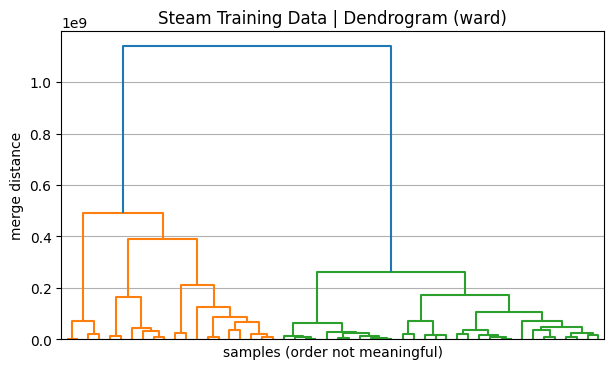

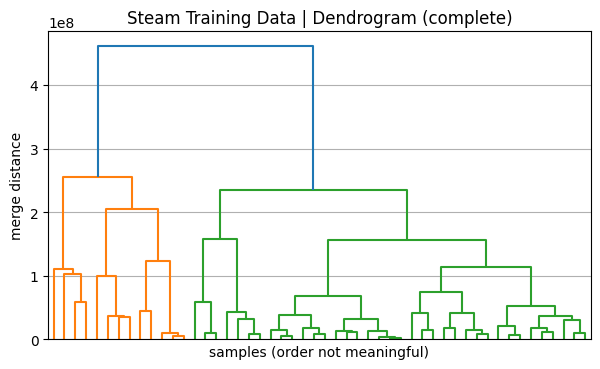

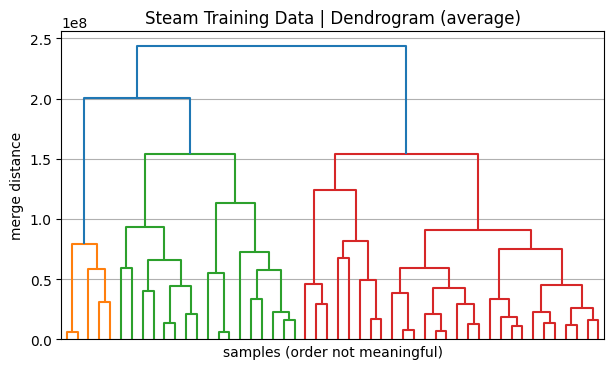

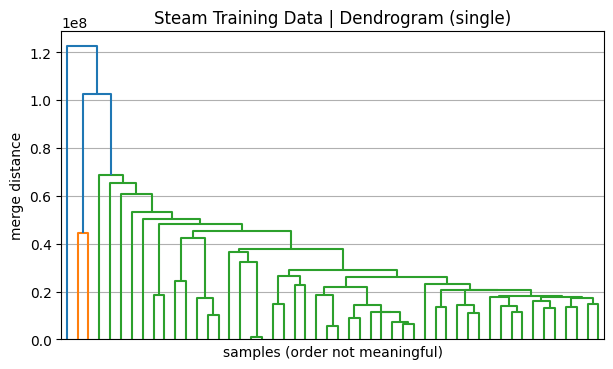

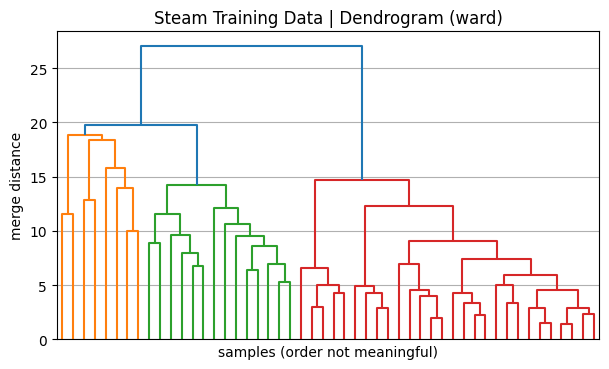

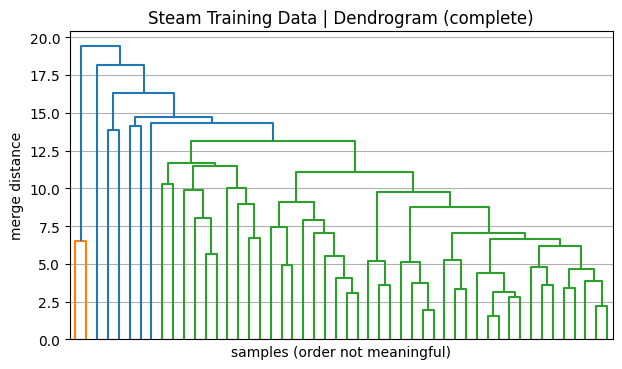

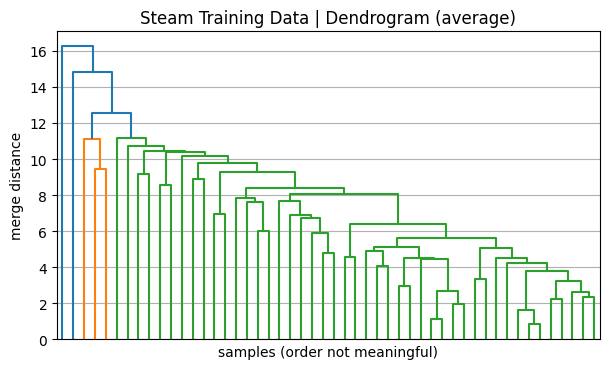

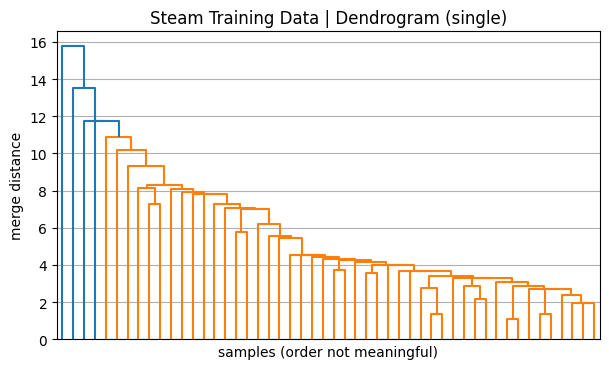

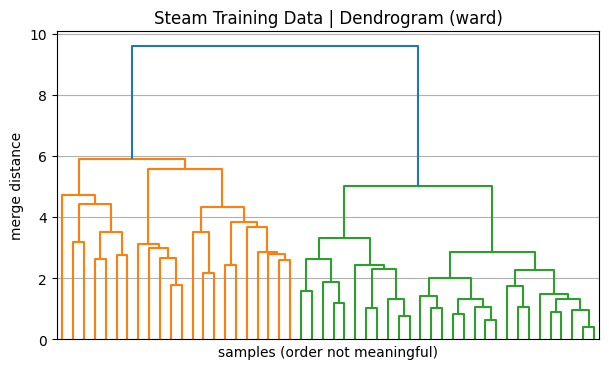

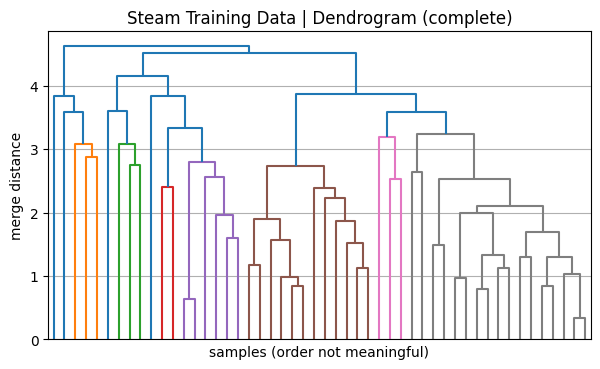

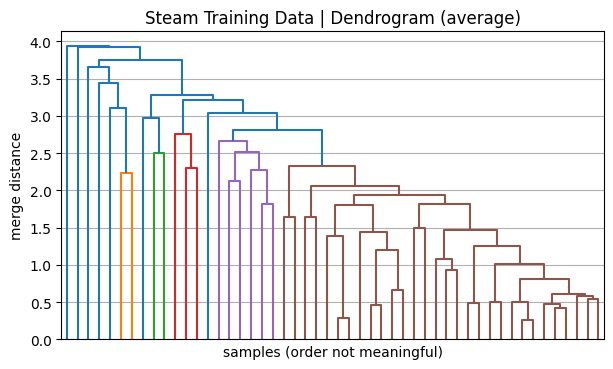

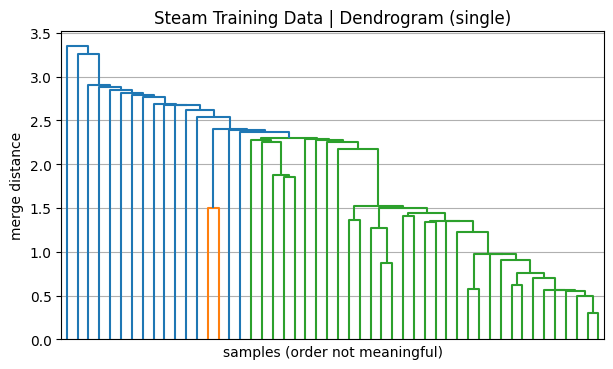

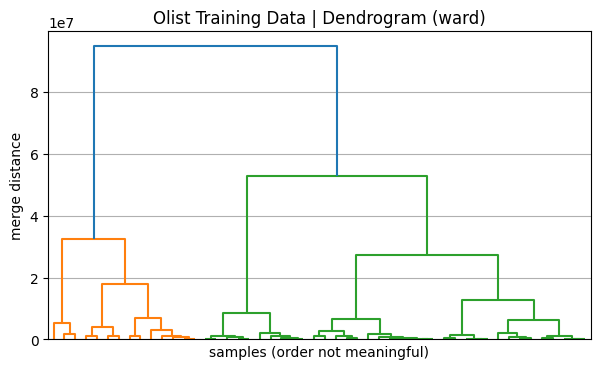

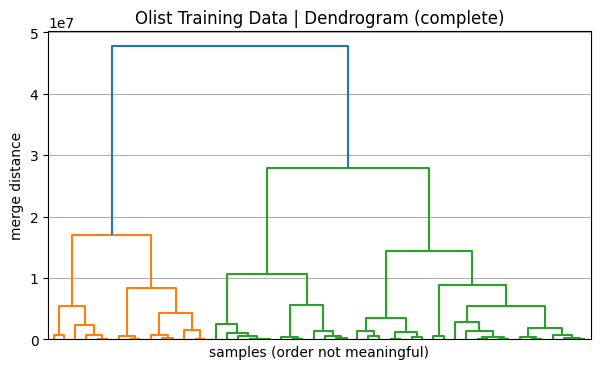

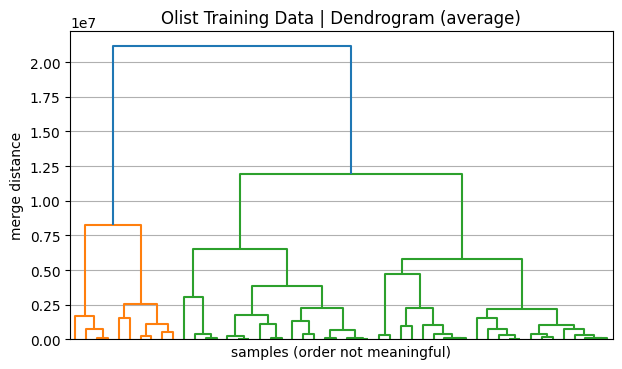

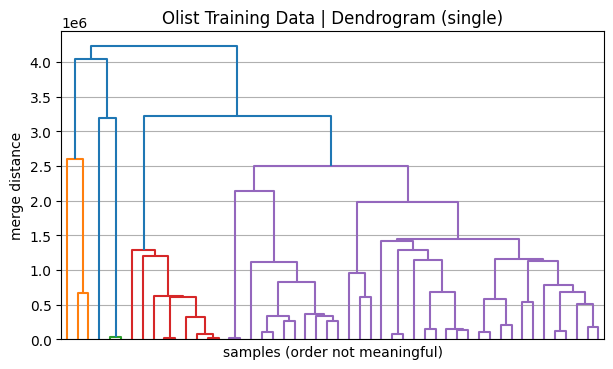

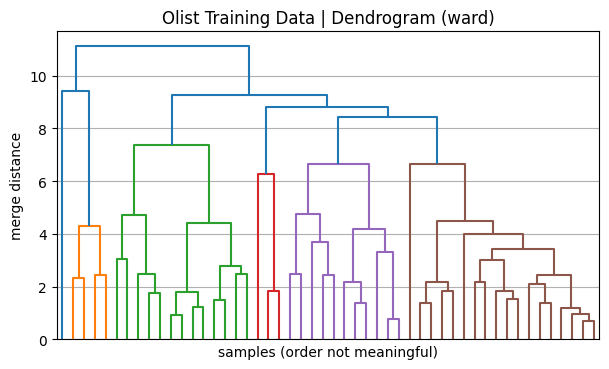

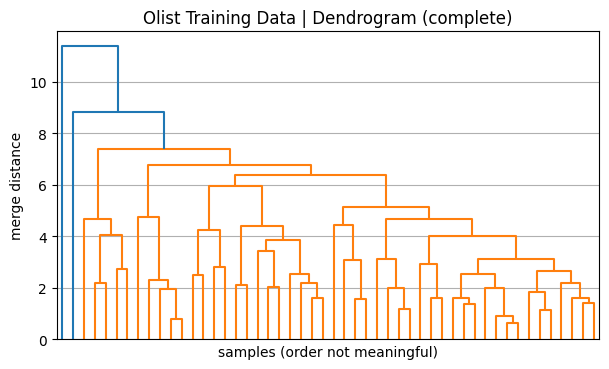

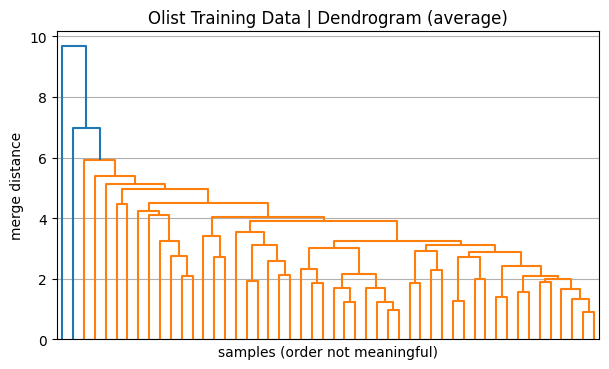

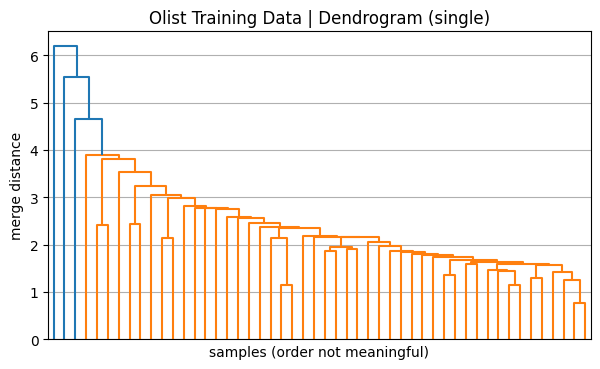

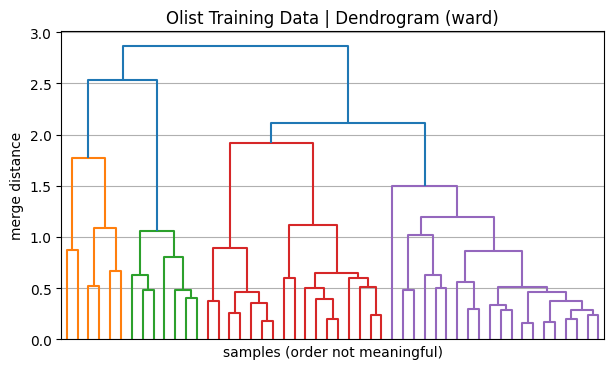

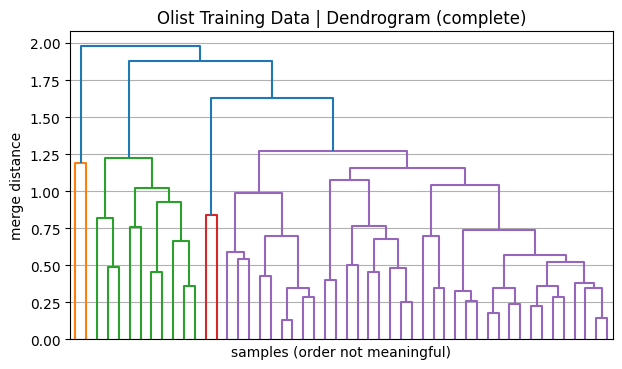

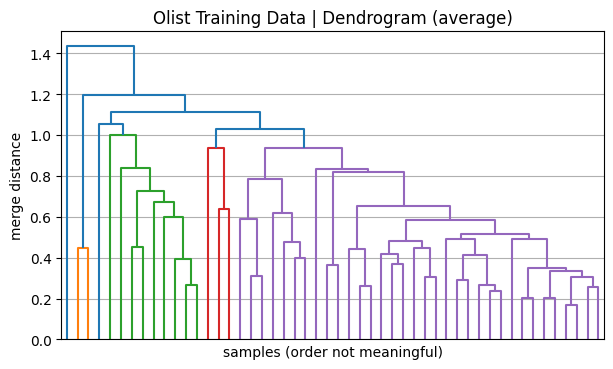

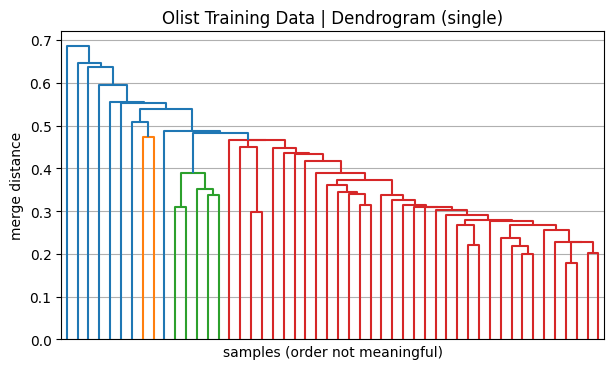

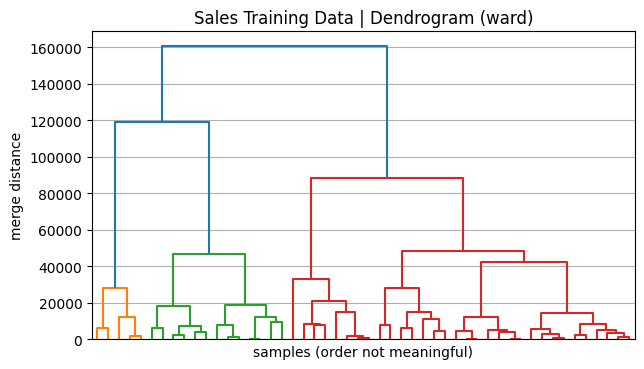

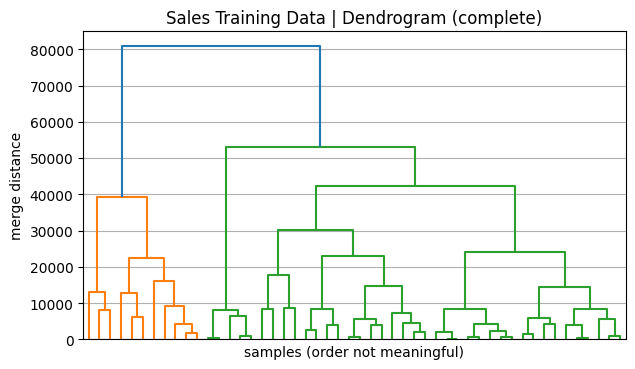

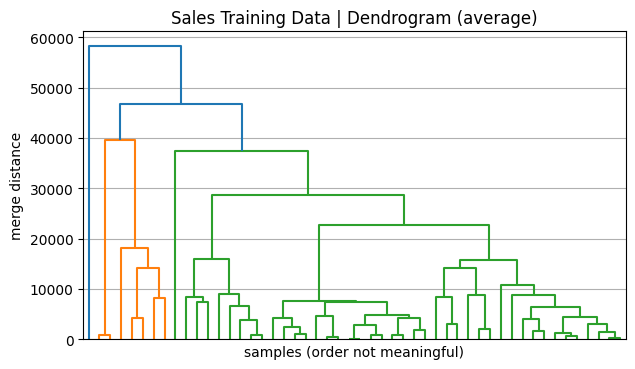

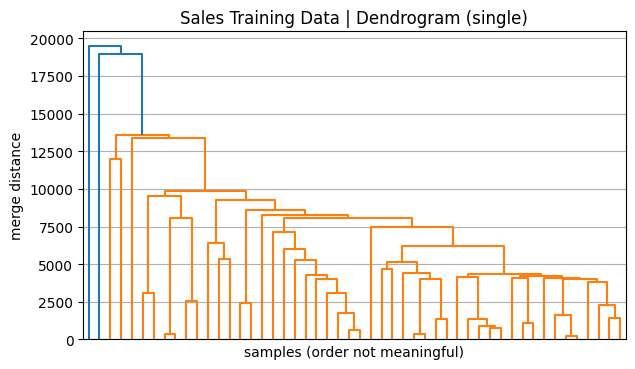

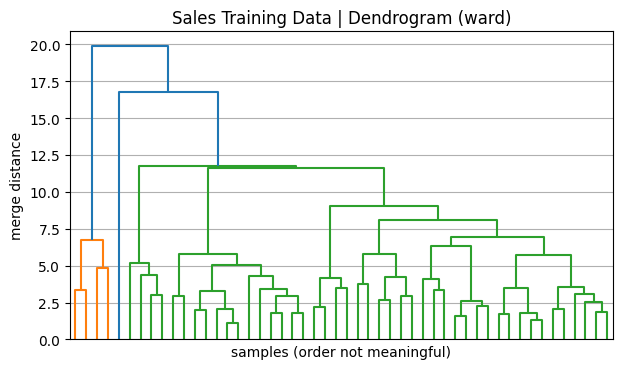

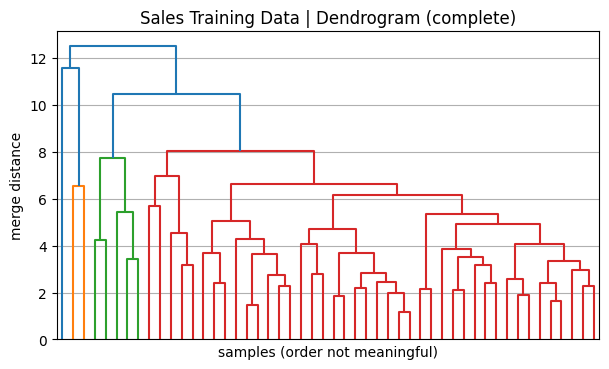

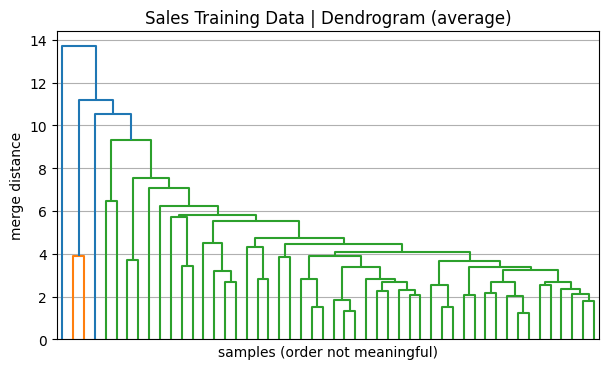

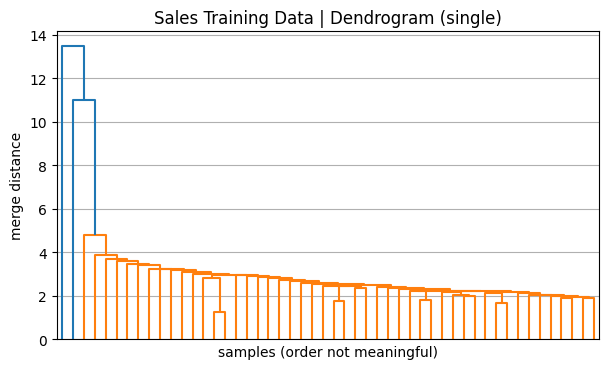

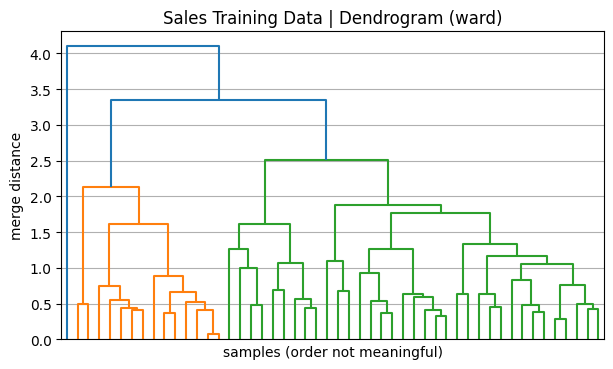

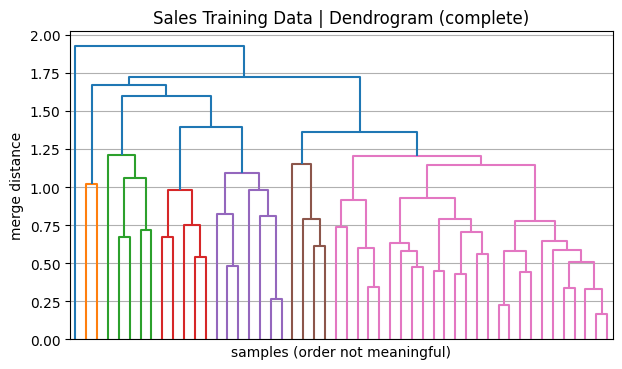

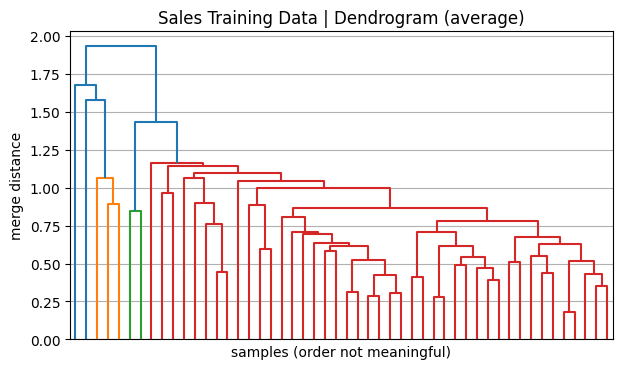

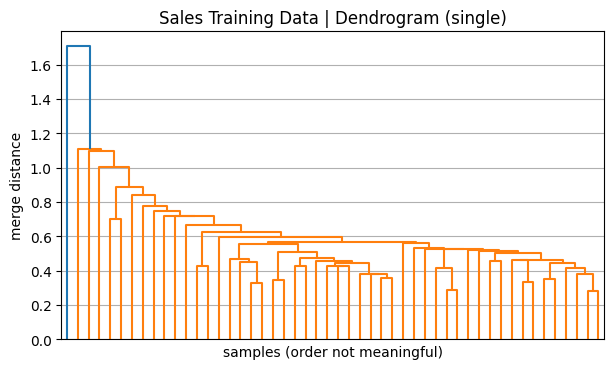


================ Summary Table ================

            dataset  rows_used_for_processing  cols_used dbscan_scaler  dbscan_eps  dbscan_min_samples  dbscan_clusters  dbscan_noise_ratio hac_best_linkage  hac_avg_imbalance
Steam Training Data                     40000         50      standard    0.200000                  10                4            0.998950             ward           0.282110
Olist Training Data                     45248         10        minmax    0.400000                  10                8            0.008288             ward           0.496300
Sales Training Data                      4702         20      standard    2.000000                   5               10            0.140791             ward           0.548596


In [5]:
def cluster_explorer(
    df1,
    df2,
    df3,
    dataframe_names=None,
    random_state=42,
    dendro_max_samples=100
):
    # Simple settings for readable numbers
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = "{:.6f}".format
    rng = np.random.default_rng(random_state)

    if dataframe_names is None:
        dataframe_names = ["DataFrame 1", "DataFrame 2", "DataFrame 3"]

    dataframes = [df1, df2, df3]

    # Pick how to scale (or not)
    scalers = {
        "none": None,
        "standard": StandardScaler(),
        "minmax": MinMaxScaler()
    }

    # ----- helpers (kept short and friendly) -----
    def print_cluster_sizes(labels):
        total_points = labels.shape[0]
        noise_points = int(np.sum(labels == -1))
        cluster_ids = sorted([c for c in set(labels) if c != -1])
        print(f"Total points: {total_points}")
        print(f"Noise (labeled -1): {noise_points}")
        if len(cluster_ids) == 0:
            print("No clusters found.")
            return
        counts = Counter(labels[labels >= 0])
        for cid in cluster_ids:
            print(f"Cluster {cid}: {counts[cid]} points")
        if noise_points > 0:
            ratio = noise_points / max(1, total_points)
            if ratio <= 0.1:
                print("Tip: small noise. Likely a few outliers.")
            elif ratio <= 0.3:
                print("Tip: moderate noise. Try a slightly larger eps.")
            else:
                print("Tip: heavy noise. Try a larger eps or scale features.")

    def balance_stats(labels):
        total_points = labels.shape[0]
        counts = Counter(labels)
        sizes = np.array(sorted(counts.values(), reverse=True), dtype=float)
        k = sizes.shape[0]
        max_share = float(np.max(sizes) / total_points)
        min_share = float(np.min(sizes) / total_points)
        imbalance = float((np.max(sizes) - np.min(sizes)) / total_points)
        return {"k": k, "max_share": max_share, "min_share": min_share, "imbalance": imbalance}

    def print_balance_note(stats):
        # Simple read of how even the groups are
        if stats["k"] <= 1:
            print("Note: only one group. No clear separation.")
        elif stats["max_share"] <= 0.6 and stats["min_share"] >= 0.1:
            print("Note: groups look fairly even.")
        elif stats["max_share"] >= 0.85:
            print("Note: one group is much larger than the rest.")
    # ---------------------------------------------

    # Basic eps grids to try for DBSCAN
    def get_eps_list(scaler_name):
        if scaler_name == "standard":
            return [0.2, 0.5, 1.0, 2.0]
        if scaler_name == "minmax":
            return [0.05, 0.1, 0.2, 0.4]
        return [1.0, 2.0, 5.0, 10.0]

    summary_rows = []

    for dataset_index, current_df in enumerate(dataframes):
        current_name = dataframe_names[dataset_index]
        print("\n====================================")
        print(f"Working on: {current_name}")
        print("====================================")

        # Keep only numeric columns and drop rows with missing values
        numeric_df = current_df.select_dtypes(include=[np.number])
        row_mask = numeric_df.notnull().all(axis=1)
        numeric_df_clean = numeric_df[row_mask]

        print(f"Original shape: {current_df.shape}")
        print(f"Numeric-only shape (after dropping NaNs): {numeric_df_clean.shape}")
        print("Processing uses ALL rows. Only dendrogram pictures use a small sample.\n")

        n_rows_full, n_cols = numeric_df_clean.shape
        if n_rows_full < 5 or n_cols < 1:
            print("Not enough numeric data here. Skipping.")
            continue

        # Track how even HAC is for each linkage style
        hac_linkage_scores = {"ward": [], "complete": [], "average": [], "single": []}

        # Track best DBSCAN result across scalers
        best_dbscan_overall = {
            "score": -1.0,
            "scaler": None,
            "eps": None,
            "min_samples": None,
            "labels": None,
            "clusters": 0,
            "noise_ratio": 1.0
        }

        for scaler_name, scaler in scalers.items():
            print("\n------------------------------------")
            print(f"Scaling method: {scaler_name}")
            if scaler is None:
                data_full = numeric_df_clean.values
                print("Note: no scaling. Distances use original units.")
            else:
                data_full = scaler.fit_transform(numeric_df_clean.values)
                print("Scaled data so features are on a similar scale.")

            number_rows, number_cols = data_full.shape

            # =============== DBSCAN (density-based) ===============
            print("\nDBSCAN quick sweep")
            eps_list = get_eps_list(scaler_name)
            min_samples_list = [5, 10]
            print(f"Trying eps: {eps_list}")
            print(f"Trying min_samples: {min_samples_list}")
            print("eps | min_samples | clusters | noise_ratio")
            print("------------------------------------------")

            local_best = {"score": -1.0}
            for eps in eps_list:
                for ms in min_samples_list:
                    db = DBSCAN(eps=eps, min_samples=ms)
                    labels = db.fit_predict(data_full)
                    clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
                    noise_ratio = float(np.mean(labels == -1))
                    print(f"{eps:>3} | {ms:12} | {clusters_found:8} | {noise_ratio:.3f}")

                    # Simple score: prefer 2–10 clusters and less noise
                    good = 1 if 2 <= clusters_found <= 10 else 0
                    score = good * (1.0 - noise_ratio)
                    if score > local_best["score"]:
                        local_best = {
                            "score": score,
                            "eps": eps,
                            "min_samples": ms,
                            "labels": labels,
                            "clusters": clusters_found,
                            "noise_ratio": noise_ratio
                        }

            if local_best["labels"] is not None:
                print("\nDBSCAN best", f"(eps={local_best['eps']}, min_samples={local_best['min_samples']})")
                print_cluster_sizes(local_best["labels"])
                if local_best["clusters"] >= 2 and local_best["noise_ratio"] <= 0.2:
                    print("DBSCAN read: clear groups with few outliers.")
                elif local_best["clusters"] >= 2 and local_best["noise_ratio"] > 0.2:
                    print("DBSCAN read: groups exist, but many outliers. Try a larger eps.")
                elif local_best["clusters"] <= 1 and local_best["noise_ratio"] < 0.2:
                    print("DBSCAN read: almost everything merged. Try a smaller eps.")
                else:
                    print("DBSCAN read: not much structure. Try another scaler.")
            else:
                print("\nDBSCAN best: none")

            if local_best["score"] > best_dbscan_overall["score"]:
                best_dbscan_overall.update({
                    "score": local_best["score"],
                    "scaler": scaler_name,
                    "eps": local_best["eps"],
                    "min_samples": local_best["min_samples"],
                    "labels": local_best["labels"],
                    "clusters": local_best["clusters"],
                    "noise_ratio": local_best["noise_ratio"]
                })

            # =============== HAC (hierarchical) ===============
            print("\nHAC (tries different ways to build a tree)")
            print("We will test: ward, complete, average, single")
            k_values = [2, 3, 4, 5]
            linkage_list = ["ward", "complete", "average", "single"]

            for link in linkage_list:
                print(f"\nLinkage: {link}")
                for k in k_values:
                    if k >= number_rows:
                        continue
                    if link == "ward":
                        hac = AgglomerativeClustering(n_clusters=k, linkage="ward")
                    else:
                        hac = AgglomerativeClustering(n_clusters=k, linkage=link, metric="euclidean")
                    labels = hac.fit_predict(data_full)
                    print(f"k={k} sizes:")
                    print_cluster_sizes(labels)
                    stats = balance_stats(labels)
                    print_balance_note(stats)
                    hac_linkage_scores[link].append(stats["imbalance"])

                # Only the dendrogram is plotted, and it uses a small sample
                if number_rows > 2:
                    try:
                        if number_rows > dendro_max_samples:
                            print(f"Drawing dendrogram on a {dendro_max_samples}-row sample.")
                            sample_idx = rng.choice(number_rows, size=dendro_max_samples, replace=False)
                            data_for_dendro = data_full[sample_idx]
                        else:
                            print(f"Drawing dendrogram on all {number_rows} rows.")
                            data_for_dendro = data_full

                        Z = linkage(data_for_dendro, method=link)
                        plt.figure(figsize=(7, 4))
                        dendrogram(Z, no_labels=True, count_sort=True)
                        plt.title(f"{current_name} | Dendrogram ({link})")
                        plt.xlabel("samples (order not meaningful)")
                        plt.ylabel("merge distance")
                        plt.grid(True)
                        print("Tip: a tall jump near the top means two big groups were far apart.")
                    except Exception as e:
                        print(f"Could not draw dendrogram for '{link}': {e}")

        # Pick the HAC linkage with the lowest average imbalance
        print("\n========== HAC Linkage Recommendation ==========")
        avg_scores = {}
        for link, vals in hac_linkage_scores.items():
            avg_scores[link] = float(np.mean(vals)) if len(vals) > 0 else float("inf")
        for link in ["ward", "complete", "average", "single"]:
            if np.isfinite(avg_scores[link]):
                print(f"{link}: average imbalance {avg_scores[link]:.3f} (lower is better)")
            else:
                print(f"{link}: no score")

        best_link = min(avg_scores, key=avg_scores.get)
        best_val = avg_scores[best_link]
        best_link_text = best_link if np.isfinite(best_val) else "n/a"
        if best_link_text != "n/a":
            print(f"Recommended linkage: {best_link_text}")

        # Add one summary row for this dataset
        summary_rows.append({
            "dataset": current_name,
            "rows_used_for_processing": int(n_rows_full),
            "cols_used": int(n_cols),
            "dbscan_scaler": best_dbscan_overall["scaler"],
            "dbscan_eps": best_dbscan_overall["eps"],
            "dbscan_min_samples": best_dbscan_overall["min_samples"],
            "dbscan_clusters": int(best_dbscan_overall["clusters"]),
            "dbscan_noise_ratio": float(best_dbscan_overall["noise_ratio"]),
            "hac_best_linkage": best_link_text,
            "hac_avg_imbalance": None if not np.isfinite(best_val) else float(best_val)
        })

    # Show all dendrograms
    plt.show()

    # Print a clear summary table
    summary_df = pd.DataFrame(summary_rows)
    print("\n================ Summary Table ================\n")
    print(summary_df.to_string(index=False))

    return summary_df

summary = cluster_explorer(
    X_train_steam,
    X_train_olist,
    X_train_sales,
    dataframe_names=["Steam Training Data", "Olist Training Data", "Sales Training Data"],
    random_state=random_state,
    dendro_max_samples=50
)
